# Pytorch-VDSR Demo

In [1]:
!git clone https://github.com/twtygqyy/pytorch-vdsr.git

Cloning into 'pytorch-vdsr'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142
Receiving objects: 100% (142/142), 85.10 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [113]:
# Load the package you are going to use
import sys
sys.path.append('/content/pytorch-vdsr')
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
# Load the pretrained model
model = torch.load(f"/content/model_epoch_50.pth")["model"]

In [115]:
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('model_scripted.pt')

In [116]:
!pip install nni

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import sys
sys.path.append('/content/pytorch-vdsr')

In [118]:
from vdsr import Net
from torchsummary import summary


In [120]:
model

Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (6): Conv_ReLU_Bl

In [119]:
summary(model,(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             576
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,864
              ReLU-4         [-1, 64, 256, 256]               0
   Conv_ReLU_Block-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,864
              ReLU-7         [-1, 64, 256, 256]               0
   Conv_ReLU_Block-8         [-1, 64, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          36,864
             ReLU-10         [-1, 64, 256, 256]               0
  Conv_ReLU_Block-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
             ReLU-13         [-1, 64, 256, 256]               0
  Conv_ReLU_Block-14         [-1, 64, 2

  - This model is trained on [291](https://drive.google.com/open?id=1Rt3asDLuMgLuJvPA1YrhyjWhb97Ly742) images with data augmentation
  - No bias is used in this implementation, and the gradient clipping's implementation is different from paper

In [89]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/content/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/content/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")

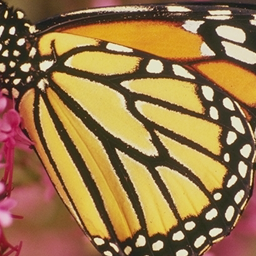

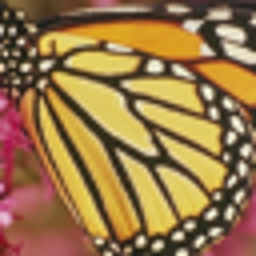

In [90]:
display(im_gt)
display(im_b)

In [91]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

In [92]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [93]:
# Calculate the PNSR for bicubic interpolation
# For best PSNR score, you will have to use Matlab for color space transformation, 
# since it is different from Python's implementation
psnr_bicubic = PSNR(im_gt_y, im_b_y)
print('psnr for bicubic is {}dB'.format(psnr_bicubic))

psnr for bicubic is 20.824648960041763dB


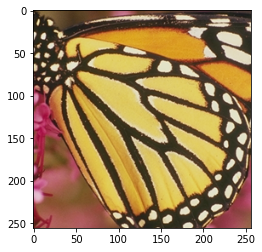

In [94]:
plt.imshow(im_gt)

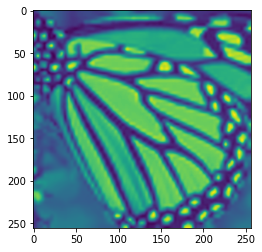

In [95]:
# Prepare for the input, a pytorch tensor
im_input = im_b_y/255.
plt.imshow(im_input)
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [96]:
# Let's try the network feedforward in cpu mode
model = model.cpu()

In [97]:
im_input.shape

torch.Size([1, 1, 256, 256])

In [98]:
# Let's see how long does it take for processing
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in cpu mode".format(elapsed_time))

It takes 0.5025811195373535s for processing in cpu mode


In [99]:
im_input.shape

torch.Size([1, 1, 256, 256])

In [100]:
# Now let's try the network feedforward in gpu mode
model = model.cuda()
im_input = im_input.cuda()

In [101]:
# Let's see how long does it take for processing in gpu mode
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in gpu mode".format(elapsed_time))

It takes 0.009487628936767578s for processing in gpu mode


In [102]:
im_input.shape

torch.Size([1, 1, 256, 256])

In [103]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [104]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = PSNR(im_gt_y, im_h_y)
print('psnr for vdsr is {}dB'.format(psnr_predicted))

psnr for vdsr is 23.856893166600265dB


In [105]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

PSNR improvement is 3.0322442065585022dB


In [106]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [107]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

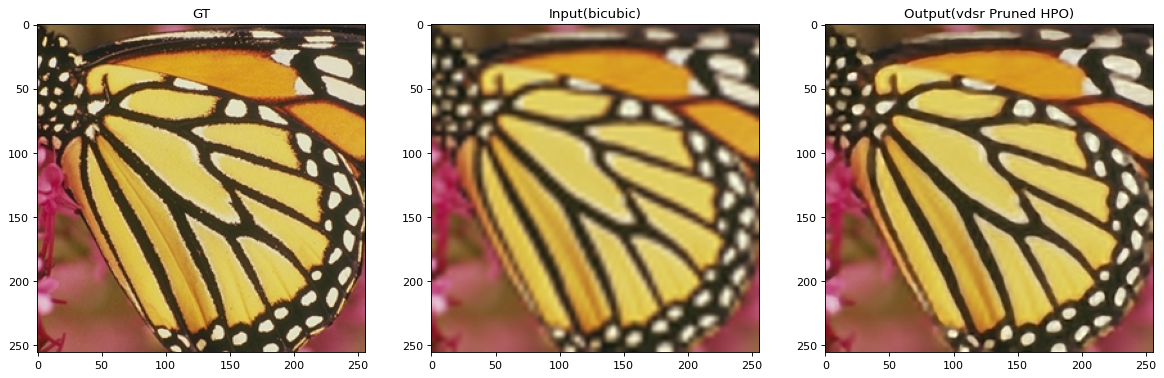

In [112]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_gt)
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(im_b)
ax.set_title("Input(bicubic)")

ax = plt.subplot("133")
ax.imshow(im_h)
ax.set_title("Output(vdsr Pruned HPO)")
plt.show()

In [109]:
model

Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (6): Conv_ReLU_Bl

In [110]:
dummy_input = torch.randn(1, 1, 256, 256, device="cuda")
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(13) ]
output_names = [ "output1" ]

torch.onnx.export(model, dummy_input, "VDSR.onnx", verbose=True, input_names=input_names, output_names=output_names)

In [111]:
!cd pytorch-vdsr